# 12장 - 다층 인공 신경망을 밑바닥부터 구현

In [13]:
from IPython.display import Image

# 인공 신경망으로 복잡한 함수 모델링

인공 신경망 이면에 있는 기본 개념은 사람의 뇌가 어떻게 복잡한 문제를 푸는지에 대한 가설과 모델을 기반으로 한다.  

맥컬룩-피츠 뉴런 모델인 로젠블라트의 퍼셉트론이 1950년대 처음 구현된 이후 수십년 동안 많은 연구자와 머신 러닝 기술자는 신경망에 대한 관심을 조금씩 잃었다. 다층 신경망을 훈련하기 좋은 방법이 없었기 때문이다.  
마침내 루멜하트, 힌튼, 윌리엄스가 1986년에 신경망을 효과적으로 훈련시키는 역전파 알고리즘을 재발견하고 널리 알리면서 신경망에 대한 관심이 다시 살아났다.  

오늘날 딥러닝 알고리즘을 사용한 고급 신경망이 이미지나 음성 인식처럼 복잡한 문제를 푸는 최고의 솔루션으로 인식되고 있다. 일상생활에서 찾을 수 있는 딥러닝 알고리즘을 활용한 제품은 구글 이미지 검색과 구글 번역기이다. 구글 번역기 스마트폰 애플리케이션은 이미지에 있는 텍스트를 자동으로 인식하여 20개가 넘는 언어로 실시간 번역할 수 있다.  

놀라운 DNN 애플리케이션 중 많은 수는 주요 테크 기업과 제약 업계에서 개발되었다.  
- 사진 이미지 태깅(tagging)을 위한 페이스북의 DeepFace
- 중국어 음성 검색을 지원하는 바이두의 DeepSpeech
- 구글의 새로운 언어 번역 서비스
- 신약 개발과 독성 예측에 사용되는 새로운 기법
- 훈련된 피부과 전문의와 비슷한 정확도로 피부암을 진단할 수 있는 모바일 애플리케이션 
- 유전자 서열에서 단백질 3D 구조 예측
- 카메라 비디오 스트림과 같은 관측 데이터만 사용하여 교통 체증 속에서 운전하는 방법 학습  

## 단일층 신경망 요약

다층 신경망 구조를 본격적으로 배우기 전에 단일층 신경망 네트워크 개념을 간단히 되새겨 보자. 

In [14]:
Image(url='https://git.io/JLdrS', width=600) 

위의 그림은 **아달린**(ADAptive LInear NEuron, Adaline) 알고리즘이다.  

2장에서 이진 분류를 수행하는 아달린 알고리즘을 구현했다. 경사 하강법 최적화 알고리즘을 사용하여 모델 가중치를 학습했다. 에포크마다 가중치 벡터 w를 업데이트 하기 위해 다음 공식을 사용한다.  
$$w: w+\Delta w, 여기서 \Delta w=-\eta \nabla J(w)$$  

다른 말로 하면 전체 훈련 데이터셋에 대한 그레이디언트를 계산하고 그레이디언트 $\nabla J(w)$의 반대 방향으로 진행하도록 모델 가중치를 업데이트했다. 최적의 모델 가중치를 찾기 위해 **제곱 오차합**(Sum of Squared Errors, SSE) 비용 함수 $J(w)$로 정의된 목적 함수를 최적화한다. 또 학습률 $\eta$를 그레이디언트에 곱한다. 학습률은 비용 함수의 전역 최솟값을 지나치지 않도록 학습 속도를 저절하기 위해 신중하게 선택해야 한다.  

경사 하강법 최적화에서는 에포크마다 모든 가중치를 동시에 업데이트한다. 가중치 벡터 w에 있는 각각의 가중치 $w_{j}$에 대한 편도 함수는 다음과 같이 정의한다.  
$${\partial \over \partial w_{j}}J(w)=-\sum_{i}(y^{(i)}-a^{(i)})x^{(i)}_{j}$$  

여기서 $y^{(i)}$는 특정 샘풀 $x^{(i)}$의 타깃 클래스 레이블이다. $a^{(i)}$는 뉴련의 활성화 출력이다. 아달린은 선형 함수를 사용하므로 활성화 함수 $\phi(\cdot)$는 다음과 같이 정의한다.  
$$\phi(z)=z=a$$  

여기서 최종 입력 z는 입력층과 출력층을 연결하는 가중치의 선형 결합이다.  
$$z = \sum_{j}w_{j}x_{j}=w^{T}x$$  

업데이트할 그레이디언트를 계산하기 위해 활성화 함수를 사용했지만, 예측을 위해서는 임계 함수를 구현하여 연속적인 출력 값을 이진 클래스 레이블로 압축했다.  
$$\widehat{y} = \begin{Bmatrix} 1 & g(z) \ge 0 일 때 \\ -1  & 그 외 \end{Bmatrix}$$  



## 다층 신경망 구조

In [15]:
Image(url='https://git.io/JLdrx', width=600)

위 그림에 나타난 MLP는 입력층 하나, 은닉층 하나, 출력층 하나를 가진다.  
은닉층의 유닛은 입력층과 완전 연결되어 있고, 출력층은 은닉층과 완전 연결되어 있다.  
하나 이상의 은닉층을 가진 네트워크를 **심층 인공 신경망**(deep artifical neural network)이라고 한다.  

이진 분류 작업에는 츨력층의 유닛이 하나여도 충분하지만, 위의 그림은 **OvA**(One-versus-All)기법을 적용하여 다중 분류를 수행할 수 있는 일반적인 신경망 형태이다.  
예를 들어 잘 알고 있는 붓꽃 데이터셋의 클래스 레이블 세 개(0=Setosa, 1=Versicolor, 2=Virginica)를 다음과 같이 인코딩할 수 있다.  
$$0=\begin{bmatrix}1\\0\\0 \end{bmatrix},1=\begin{bmatrix}0\\1\\0 \end{bmatrix}, 2=\begin{bmatrix}0\\0\\1 \end{bmatrix}$$  

원-핫 벡터를 사용하면 훈련 데이터셋에 있는 고유한 클래스 레이블 개수에 구애받지 않고 분류 문제를 해결할 수 있다.  

In [16]:
Image(url='https://git.io/JLdrp', width=500) 

위의 그림은 다층 퍼셉트론의 표기법을 나타낸다.

## 정방향 계산으로 신경망 활성화 출력 계산

이 절에서는 MLP 모델의 출력을 계산하는 **정방향 계산**(forward propagation) 과정을 설명한다.  
MLP 모델 학습과 어떻게 관련되는지 이해하기 위해 세 단계로 MLP 학습 과정을 요약해보자.  
1. 입력층에서 시작해서 정방향으로 훈련 데이터의 패턴을 네트워크에 전파하여 출력을 만든다. 
2. 네트워크의 출력을 기반으로 나중에 설명할 비용 함수를 이용하여 최소화해야 할 오차를 계산한다. 
3. 네트워크에 있는 모든 가중치에 대한 도함수를 찾아 오차를 역전파하고 모델을 업데이트한다.

이 세 단계를 여러 에포크 동안 반복하고 MLP 가중치를 학습한다. 그런 다음 클래스 레이블을 예측하기 위해 정방향 계산으로 네트워크의 출력을 만들고 임계 함수를 적용한다. 이 클래스 레이블은 이전 절에서 설명했던 원-핫 인코딩으로 표현된다.  
</br>
</br>
</br>
이제 훈련 데이터에 있는 패턴으로부터 출력을 만들기 위해 정방향 계산 과정을 따라가보자.  
은닉층에 있는 모든 유닛은 입력층에 있는 모든 유닛과 연결되어 있기 때문에 먼저 다음과 같이 은닉층 $a_{1}^{(h)}$의 활성화 출력을 계산한다.  
$$z^{(h)}_{1} = a^{(in)}_{0}w^{(h)}_{0,1}+ a^{(in)}_{1}w^{(h)}_{1,1}+\cdots+a^{(in)}_{m}w^{(h)}_{m,j}$$  
$$a^{(h)}_{1}=\phi(z^{(h)}_{1})$$   

여기서 $z^{(h)}_{1}$는 최종 입력이고 $\phi(\cdot)$는 활성화 함수이다. 이 함수는 그레이디언트 기반 방식을 사용하여 뉴런과 연결된 가중치를 학습하기 위해 미분 가능해야 한다.  
이미지 분류 같은 복잡한 문제를 해결하기 위해서는 MLP 모델에 비선형 활성화 함수를 사용해야 한다. 예를 들어 3장 로지스틱 회귀에 관한 절에서 보았던 시그모이드(로지스틱) 활성화 함수가 있다.  

아래의 그림은 시그모이드 함수이다.

In [17]:
Image(url='https://git.io/JLdoe', width=500) 

MLP는 대표적인 피드포워드 인공 신경망의 하나이다. **피드포워드**(feed forward)란 용어는 각 층에서 입력을 순환시키지 않고 다음 층으로 전달한다는 의미이다.  

# 손글씨 숫자 분류

이 절에서 잘 알려진 **MNIST**(Mixed National Institue of Standards and Technology) 데이터셋의 손글씨 숫자를 분류하는 다층 신경망을 구현하여 훈련시켜 보자. 

## MNIST 데이터셋 구하기

In [18]:
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz


--2022-11-20 14:13:04--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: 'train-images-idx3-ubyte.gz.1'

train-images-idx3-u 100%[===================>]   9.45M  7.05MB/s    in 1.3s    

2022-11-20 14:13:06 (7.05 MB/s) - 'train-images-idx3-ubyte.gz.1' saved [9912422/9912422]

--2022-11-20 14:13:06--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: 'train-labels-idx1-ubyte.gz.1'

train-labels-idx1-u 100%[===================>]  28.20K  --.-KB/s    in 0s      

2022-11-20 14

In [19]:
# MNIST 데이터 압축을 푸는 코드

import sys
import gzip
import shutil
import os

if (sys.version_info > (3, 0)):
    writemode = 'wb'
else:
    writemode = 'w'

zipped_mnist = [f for f in os.listdir() if f.endswith('ubyte.gz')]
for z in zipped_mnist:
    with gzip.GzipFile(z, mode='rb') as decompressed, open(z[:-3], writemode) as outfile:
        outfile.write(decompressed.read()) 

In [20]:
import os
import struct
import numpy as np
 
def load_mnist(path, kind='train'):
    """`path`에서 MNIST 데이터 불러오기"""
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                             dtype=np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2 # MNIST 픽셀 값을 -1에서 1 사이로 정규화
 
    return images, labels

In [21]:
!ls

README.md                    t10k-labels-idx1-ubyte.gz.1
ch12.ipynb                   train-images-idx3-ubyte
t10k-images-idx3-ubyte       train-images-idx3-ubyte.gz
t10k-images-idx3-ubyte.gz    train-images-idx3-ubyte.gz.1
t10k-images-idx3-ubyte.gz.1  train-labels-idx1-ubyte
t10k-labels-idx1-ubyte       train-labels-idx1-ubyte.gz
t10k-labels-idx1-ubyte.gz    train-labels-idx1-ubyte.gz.1


In [22]:
X_train, y_train = load_mnist('', kind='train')
print('행: %d, 열: %d' % (X_train.shape[0], X_train.shape[1]))

행: 60000, 열: 784


In [23]:
X_test, y_test = load_mnist('', kind='t10k')
print('행: %d, 열: %d' % (X_test.shape[0], X_test.shape[1]))

행: 10000, 열: 784


각 클래스의 첫 번째 이미지를 그려본다.

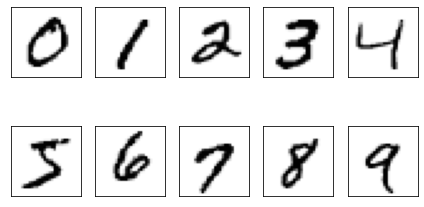

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('images/12_5.png', dpi=300)
plt.show()

또 손글씨마다 얼마나 차이가 나는지 보기 위해 같은 숫자의 샘플을 여러 개 출력해보자.  
숫자 7 샘플 25개를 그린다.

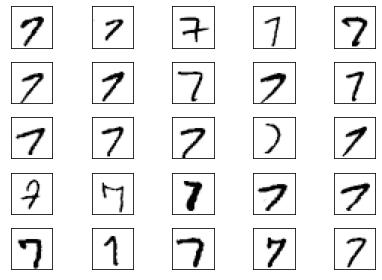

In [25]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('images/12_6.png', dpi=300)
plt.show()

이전 단계를 모두 진행한 후 스케일 된 이미지를 새로운 파이썬 세션에서 빠르게 읽을 수 있는 포맷으로 저장하는 것이 좋다. 이렇게 하면 데이터를 읽고 전처리하는 오버헤드를 피할 수 있다.  
넘파이 배열을 사용할 때 다차원 배열을 디스크에 저장하는 효율적이고 가장 간편한 방법은 넘파이 `savez`함수이다.   

간단히 말해서 `savez` 함수는 9장에서 사용했던 파이썬의 `pickle` 모듈과 비슷하다. 하지만 넘ㅁ파이 배열을 저장하는 데 최적화되어 있다.  
`savez` 함수는 데이터를 압축하여 `.npy` 포맷 파일을 담고 있는 `.npz` 파일을 만든다.  
여기서는 `savez` 대신에 `savez_compressed`를 사용한다. 이 함수는 `savez`와 사용법은 같지만 파일 크기를 더 작게 압축한다.

In [26]:
import numpy as np

np.savez_compressed('mnist_scaled.npz', 
                    X_train=X_train,
                    y_train=y_train,
                    X_test=X_test,
                    y_test=y_test)

`.npz` 파일을 만든 후 다음 코드처럼 `load` 함수로 전처리된 MNIST 이미지 배열을 로드할 수 있다. 

In [28]:
mnist = np.load('mnist_scaled.npz')
mnist.files

['X_train', 'y_train', 'X_test', 'y_test']

In [29]:
X_train, y_train, X_test, y_test = [mnist[f] for f in ['X_train', 'y_train', 
                                    'X_test', 'y_test']]

del mnist

X_train.shape

(60000, 784)

## 다층 퍼셉트론 구현

In [30]:
import numpy as np
import sys


class NeuralNetMLP(object):
    """피드포워드 신경망 / 다층 퍼셉트론 분류기

    매개변수

    ------------
    n_hidden : int (기본값: 30)
        은닉 유닛 개수
    l2 : float (기본값: 0.)
        L2 규제의 람다 값
        l2=0이면 규제 없음. (기본값)
    epochs : int (기본값: 100)
        훈련 세트를 반복할 횟수
    eta : float (기본값: 0.001)
        학습률
    shuffle : bool (기본값: True)
        에포크마다 훈련 세트를 섞을지 여부
        True이면 데이터를 섞어 순서를 바꿉니다
    minibatch_size : int (기본값: 1)
        미니 배치의 훈련 샘플 개수
    seed : int (기본값: None)
        가중치와 데이터 셔플링을 위한 난수 초깃값

    속성
    -----------
    eval_ : dict
      훈련 에포크마다 비용, 훈련 정확도, 검증 정확도를 수집하기 위한 딕셔너리

    """
    def __init__(self, n_hidden=30,
                 l2=0., epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None):

        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size

    def _onehot(self, y, n_classes):
        """레이블을 원-핫 방식으로 인코딩합니다

        매개변수
        ------------
        y : 배열, 크기 = [n_samples]
            타깃 값.
        n_classes : int
            클래스 개수

        반환값
        -----------
        onehot : 배열, 크기 = (n_samples, n_labels)

        """
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

    def _sigmoid(self, z):
        """로지스틱 함수(시그모이드)를 계산합니다"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def _forward(self, X):
        """정방향 계산을 수행합니다"""

        # 단계 1: 은닉층의 최종 입력
        # [n_samples, n_features] dot [n_features, n_hidden]
        # -> [n_samples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h

        # 단계 2: 은닉층의 활성화 출력
        a_h = self._sigmoid(z_h)

        # 단계 3: 출력층의 최종 입력
        # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_samples, n_classlabels]
        z_out = np.dot(a_h, self.w_out) + self.b_out

        # 단계 4: 출력층의 활성화 출력
        a_out = self._sigmoid(z_out)

        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        """비용 함수를 계산합니다

        매개변수
        ----------
        y_enc : 배열, 크기 = (n_samples, n_labels)
            원-핫 인코딩된 클래스 레이블
        output : 배열, 크기 = [n_samples, n_output_units]
            출력층의 활성화 출력 (정방향 계산)

        반환값
        ---------
        cost : float
            규제가 포함된 비용

        """
        L2_term = (self.l2 *
                   (np.sum(self.w_h ** 2.) +
                    np.sum(self.w_out ** 2.)))

        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term
        
        # 다른 데이터셋에서는 극단적인 (0 또는 1에 가까운) 활성화 값이 나올 수 있습니다.
        # 파이썬과 넘파이의 수치 연산이 불안정하기 때문에 "ZeroDivisionError"가 발생할 수 있습니다.
        # 즉, log(0)을 평가하는 경우입니다.
        # 이 문제를 해결하기 위해 로그 함수에 전달되는 활성화 값에 작은 상수를 더합니다.
        #
        # 예를 들어:
        #
        # term1 = -y_enc * (np.log(output + 1e-5))
        # term2 = (1. - y_enc) * np.log(1. - output + 1e-5)
        
        return cost

    def predict(self, X):
        """클래스 레이블을 예측합니다

        매개변수
        -----------
        X : 배열, 크기 = [n_samples, n_features]
            원본 특성의 입력층

        반환값:
        ----------
        y_pred : 배열, 크기 = [n_samples]
            예측된 클래스 레이블

        """
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
        """훈련 데이터에서 가중치를 학습합니다

        매개변수
        -----------
        X_train : 배열, 크기 = [n_samples, n_features]
            원본 특성의 입력층
        y_train : 배열, 크기 = [n_samples]
            타깃 클래스 레이블
        X_valid : 배열, 크기 = [n_samples, n_features]
            훈련하는 동안 검증에 사용할 샘플 특성
        y_valid : 배열, 크기 = [n_samples]
            훈련하는 동안 검증에 사용할 샘플 레이블

        반환값:
        ----------
        self

        """
        n_output = np.unique(y_train).shape[0]  # number of class labels
        n_features = X_train.shape[1]

        ########################
        # 가중치 초기화
        ########################

        # 입력층 -> 은닉층 사이의 가중치
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                      size=(n_features, self.n_hidden))

        # 은닉층 -> 출력층 사이의 가중치
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                        size=(self.n_hidden, n_output))

        epoch_strlen = len(str(self.epochs))  # 출력 포맷을 위해
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

        y_train_enc = self._onehot(y_train, n_output)

        # 훈련 에포크를 반복합니다
        for i in range(self.epochs):

            # 미니 배치로 반복합니다
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size +
                                   1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # 정방향 계산
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

                ##################
                # 역전파
                ##################

                # [n_examples, n_classlabels]
                delta_out = a_out - y_train_enc[batch_idx]

                # [n_examples, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)

                # [n_examples, n_classlabels] dot [n_classlabels, n_hidden]
                # -> [n_examples, n_hidden]
                delta_h = (np.dot(delta_out, self.w_out.T) *
                           sigmoid_derivative_h)

                # [n_features, n_examples] dot [n_examples, n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, delta_h)
                grad_b_h = np.sum(delta_h, axis=0)

                # [n_hidden, n_examples] dot [n_examples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, delta_out)
                grad_b_out = np.sum(delta_out, axis=0)

                # 규제와 가중치 업데이트
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # 편향은 규제하지 않습니다
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h

                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out  # 편향은 규제하지 않습니다
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out

            #############
            # 평가
            #############

            # 훈련하는 동안 에포크마다 평가합니다
            z_h, a_h, z_out, a_out = self._forward(X_train)
            
            cost = self._compute_cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
                         X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) /
                         X_valid.shape[0])

            sys.stderr.write('\r%0*d/%d | 비용: %.2f '
                             '| 훈련/검증 정확도: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

784-100-10 크기의 MLP를 만들어 보자.  
즉, 784개의 입력 유닛(n_features), 100개의 은닉 유닛(n_hidden), 열 개의 출력 유닛(n_output)으로 구성된 신경망이다. 

In [32]:
n_epochs = 200
nn = NeuralNetMLP(n_hidden=100, 
                  l2=0.01, 
                  epochs=n_epochs, 
                  eta=0.0005,
                  minibatch_size=100, 
                  shuffle=True,
                  seed=1)

- **l2**: 과대적합을 줄이기 위한 L2 규제의 $\lambda$ 파라미터  

- **epochs**: 훈련 데이터셋을 반복할 횟수  

- **eta**: 학습률 $\eta$  

- **shuffle**: 알고리즘이 순환 고리에 갇히지 않도록 에포크를 시작하기 전에 훈련 데이터셋을 섞을지 여부  

- **seed**: 셔플과 가중치 초기화를 위한 난수 초깃값  

- **minibatch_size**: 확률적 경사 하강법에서 에포크마다 훈련 데이터셋을 나눈 미니 배치에 들어갈 훈련 샘플 개수. 전체 훈련 데이터셋에서 그레이디언트를 계산하지 않고 학습 속도를 높이기 위해 미니 배치마다 계산한다. 

In [33]:
nn.fit(X_train=X_train[:55000], 
       y_train=y_train[:55000],
       X_valid=X_train[55000:],
       y_valid=y_train[55000:])

/var/folders/tb/x7hcv5j94gn9b46c7qc1vfth0000gn/T/ipykernel_2811/1157784320.py:251: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
/var/folders/tb/x7hcv5j94gn9b46c7qc1vfth0000gn/T/ipykernel_2811/1157784320.py:253: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  valid_acc = ((np

NeuralNetMLP 구현에서 eval_ 속성을 정의하여 에포크마다 비용, 훈련 정확도, 검증 정확도를 수집했다. 이 결과를 그래프로 나타내보자.

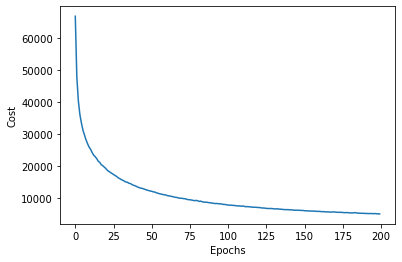

In [34]:
import matplotlib.pyplot as plt

plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
# plt.savefig('images/12_07.png', dpi=300)
plt.show()

위 그림에서 볼 수 있듯이 비용은 100번의 에포크 동안 많이 감소한다. 그리고 이후 100번의 에포크에서 천천히 수렴하는 것으로 보인다.  
하지만 175번째와 200번째 에포크 사이에 약간 경사가 있어서 에포크를 추가하여 훈련하면 비용이 더 감소할 것이다.  

다음 훈련 정확도와 검증 정확도를 보자.

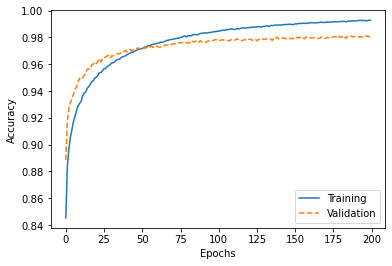

In [35]:
plt.plot(range(nn.epochs), nn.eval_['train_acc'], 
         label='Training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], 
         label='Validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
# plt.savefig('images/12_08.png', dpi=300)
plt.show()

이 그래프는 네트워크 훈련 에포크가 늘어날 수록 훈련 정확도와 검증 정확도 사이 간격이 증가한다는 것을 보여준다. 약 50번째 에포크에서 훈련 정확도오 값이 동일하고 그 이후에 너트워크는 훈련 데이터셋에 과대적합되기 시작한다.  

이 예제는 과대적합의 영향을 보여 주고 훈련 시에 훈련 정확도와 검증 정확도를 비교하는 것이 필요한 이유를 설명한다.  
과대적합을 영향을 줄이는 한 가지 방법은 규제 강도를 높이는 것이다. 예를 들어 l2=0.1로 설정한다.   

마지막으로 테스트 데이터셋에서 예측 정확도를 계산하여 모델 일반화 성능을 평가해보자.

In [38]:
y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test == y_test_pred)
       .astype(np.float) / X_test.shape[0])

print('테스트 정확도: %.2f%%' % (acc * 100))

테스트 정확도: 97.54%


/var/folders/tb/x7hcv5j94gn9b46c7qc1vfth0000gn/T/ipykernel_2811/1046544526.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.float) / X_test.shape[0])


훈련 데이터셋에 조금 과대적합되었지만 하나의 은닉층을 가진 간단한 이 신경망은 비교적 테스트 데이터셋에서 좋은 성능을 달성했다. 검증 데어터셋 정확도(97.98%)와 비슷하다.  

이 모델을 더 세밀하게 튜닝하면 은닉 유닛 개수나 규제 매개변수의 값, 학습률을 바꿀 수 있다.  
이 책에서 다루지는 않지만 널리 사용하는 다른 기법은 다음과 같다. 
- 잔차 신경망의 주요 특징인 스킵 연결(skip-connection) 추가하기
- 학습률 스케줄러를 사용하여 훈련하는 동안 학습률 바꾸기
- 인기 있는 입셉션 v3 구조에서 사용했던 것처럼 신경망의 앞쪽 층에 손실 함수 연결하기

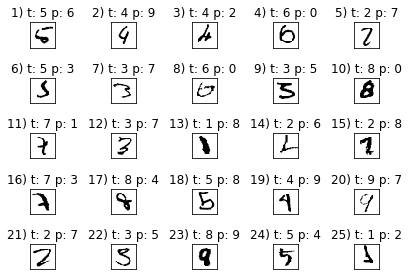

In [40]:
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('images/12_09.png', dpi=300)
plt.show()

클래스 레이블은 t이고 예측된 클래스 레이블은 p이다. 

# 인공 신경망 훈련

## 로지스틱 비용 함수 계산

$$J(w)=-\sum^{n}_{i=1}y^{[i]}log(a^{[i]})+(1-y^{[i]})log(1-a^{[i]})$$  

비용 함수 $J(W)$를 최소화하는 것이 목적이므로 네트워크의 모든 가중치에 대해 파라미터 W의 편도 함수를 계산해야 한다.  
$${\partial \over \partial w^{(l)}_{j,i}}J(W)$$  


W는 여러 행렬로 구성되어 있다. 하나의 은닉층을 가진 다층 퍼셉트론에서는 $W^{(h)}$가 입력층과 은닉층을 연결하는 가중치 행렬이고, $W^{(out)}$이 은닉층과 출력층을 연결하는 가중치 행렬이다.  
3차원 텐서 W를 그림으로 그리면 다음과 같다.

In [41]:
Image(url='https://git.io/JLdov', width=300) 

## 역전파 알고리즘 이해

핵심적으로 말해서 역전파 알고리즘을 다층 신경망에서 복잡한 비용 함수의 편미분을 효율적으로 계산하기 위한 방법으로 생각할 수 있다.   
이 편미분을 사용하여 다층 인공 신경망의 가중치 파라미터를 학습한다. 신경망은 전형적으로 고차원 특성 공간에서 비롯된 대규모 가중치를 다루어야 하기 때문에 학습하기 어렵다. 아달린이나 로지스틱 회귀처럼 단일층 신경망의 비용 함수와 달리 일반적인 신경망의 비용 함수 곡면은 볼록 함수가 아니거나 파라미터에 대해 매끄럽지 않다.  
고차원 비용 함수의 곡면에는 전역 최솟값을 찾기 위해 넘어야 할 굴곡(지역 최솟값)이 많다.  

연쇄법칙은 $f(g(x))$처럼 복잡하고 중첩된 함수의 도함수를 계산하는 방법이다.  
$${d \over dx}[f(g(x))] = {df \over dg}\cdot{dg \over dx}$$  

비슷하게 임의의 긴 합성 함수에 연쇄 법칙을 사용할 수 있다. 예를 들어 다섯 개의 다른 함수 $f(x), g(x), h(x), u(x), v(x)$가 있다고 가정해보자.  
F는 합성 함수로 $F(x)=f(g(h(u(v(x)))))$이다.  
$${dF \over dx}={d \over dx}F(x) = {d \over dx}f(g(h(u(v(x))))) = {df \over dg}\cdot{dg \over dh}\cdot{dh \over du}\cdot{du \over dv}\cdot{dv \over dx}$$  

컴퓨터 대수학에서는 이런 문제를 효율적으로 풀기 위한 여러 가지 기법을 개발했다. 이를 **자동 미분**(automatic differentiation)이라고 한다.  
자동 미분은 정방향과 역방향 두 가지 모드가 있다. 역전파는 역방향 자동 미분의 특별한 경우이다. 핵심은 정방향 모드로 연쇄 법칙을 적용하면 계산 비용이 많이 들 수 있다는 것이다.  
역방향 모드는 오른쪽에서 왼쪽으로 진행한다. 행렬과 벡터를 곱해 또 다른 벡터를 얻은 후 다음 행렬을 곱하는 식이다.  
행렬-벡터 곱셈은 행렬-행렬 곱셈보다 훨씬 계산 비용이 적게 든다. 신경망을 훈련할 때 역전파 알고리즘이 가장 인기 있는 알고리즘이 된 이유이다. 

## 역전파 알고리즘으로 신경망 훈련

In [42]:
Image(url='https://git.io/JLdoa', width=400) 

위 그림은 신경망의 정방향 계산을 나타낸다. 

역전파에서는 오차를 오른쪽에서 왼쪽으로 전파시킨다.  
(오차 역전파의 과정은 책의 수식을 참고하여 공부하자. 책 508-511 page) 

역전파 알고리즘 전체 과정을 그림으로 정리하면 다음과 같다.

In [43]:
Image(url='https://git.io/JLdoz', width=500) 

# 신경망의 수렴

손글씨 숫자 분류를 위해 신경망을 훈련시킬 때 기본 경사 하강법을 사용하지 않고 미니 배치 방식을 사용했다.   
온라인 학습에서는 한 번에 하나의 훈련 샘플(k=1)에 대해 그레이디언트를 계산하여 가중치를 업데이트했다. 확률적이지만 매우 정확한 솔루션을 만들고 기본 경사 하강법보다 훨씬 빠르게 수렴한다.  
미니 배치 학습은 확률적 경사 하강법의 특별한 경우이다. n개의 훈련 샘플 중 k개의 부분 집합에서 그레이디언트를 계산한다. 미니 배치 학습은 벡터화된 구현을 만들어 계산 효율성을 높일 수 있다는 것이 온라인 학습보다 장점이다. 기본 경사 하강법보다 훨씬 빠르게 가중치가 업데이트된다. 직관적으로 보았을 때 미니 배치 학습을 대통령 선거의 투표울을 예측하기 위해 전체 인구가 아니라 *일부 표본 집단에 설문하는 것*으로 생각할 수 있다.  

다층 신경망은 아달린, 로지스틱 회귀, 서포트 벡터 머신 같은 알고리즘보다 훨씬 훈련하기 어렵다. 다층 신경망은 일반적으로 최적화해야 할 가중치가 수백 개, 수천 개, 심지어 수백만 개가 있다.

In [44]:
Image(url='https://git.io/JLdoK', width=500) 

위의 그림은 하나의 가중치에 대한 비용 함수 곡선을 x축에 나타냈다.  
이 그림은 알고리즘이 지역 최솟값에 갇혀서는 안 된다는 것을 설명한다. 학습률을 크게 하면 지역 최솟값을 손쉽게 탈출할 수 있다. 반면 학습률이 너무 크면 전역 최솟값을 지나칠 수 있는 가능성이 높아진다.  
랜덤하게 가중치를 초기화하기 때문에 일반적으로 최적화 문제의 해는 잘못된 지점에서 출발하는 셈이다. 